In [1]:
!pip install pymc3 arviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 109.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of pymc3 to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 71.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 56.8 MB/s eta 0:00:00
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529958 sha256=5cba81b4555db36c3f8a6f6260a71e219e015699203dea117ade95c66c8c3d48
  Stored in directory: /root/.cache/pip/wheels/fb/d3/25/6c443075ee21f3b6a59a6a180b55657b012722e1b89f8ccbe8
Successfully built theano-pymc


In [3]:
# 1.2 Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns

# Optional: Warnings off
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style
sns.set(style='darkgrid')

In [4]:
# 2.1 Load preprocessed data (from previous notebook or export file)
df = pd.read_csv('BrentOilPrices.csv')

# 2.2 Convert 'Date' and calculate log returns
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y', errors='coerce')
df = df.sort_values('Date').dropna()
df['Log_Returns'] = np.log(df['Price'] / df['Price'].shift(1))
df = df.dropna()

# 2.3 Set up time index and returns array
log_returns = df['Log_Returns'].values
time_index = np.arange(len(log_returns))


In [5]:
# 3.1 Build the model
with pm.Model() as model:
    # Prior for change point (uniform across time index)
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(log_returns)-1)

    # Priors for the means before and after change point
    mu1 = pm.Normal('mu1', mu=0, sigma=0.05)
    mu2 = pm.Normal('mu2', mu=0, sigma=0.05)

    # Common standard deviation
    sigma = pm.HalfNormal('sigma', sigma=0.05)

    # Define the mean for each time step
    mu = pm.math.switch(tau >= time_index, mu1, mu2)

    # Likelihood
    returns_obs = pm.Normal('returns_obs', mu=mu, sigma=sigma, observed=log_returns)

    # Sample from posterior
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)


Output()

ERROR:pymc.stats.convergence:There were 996 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


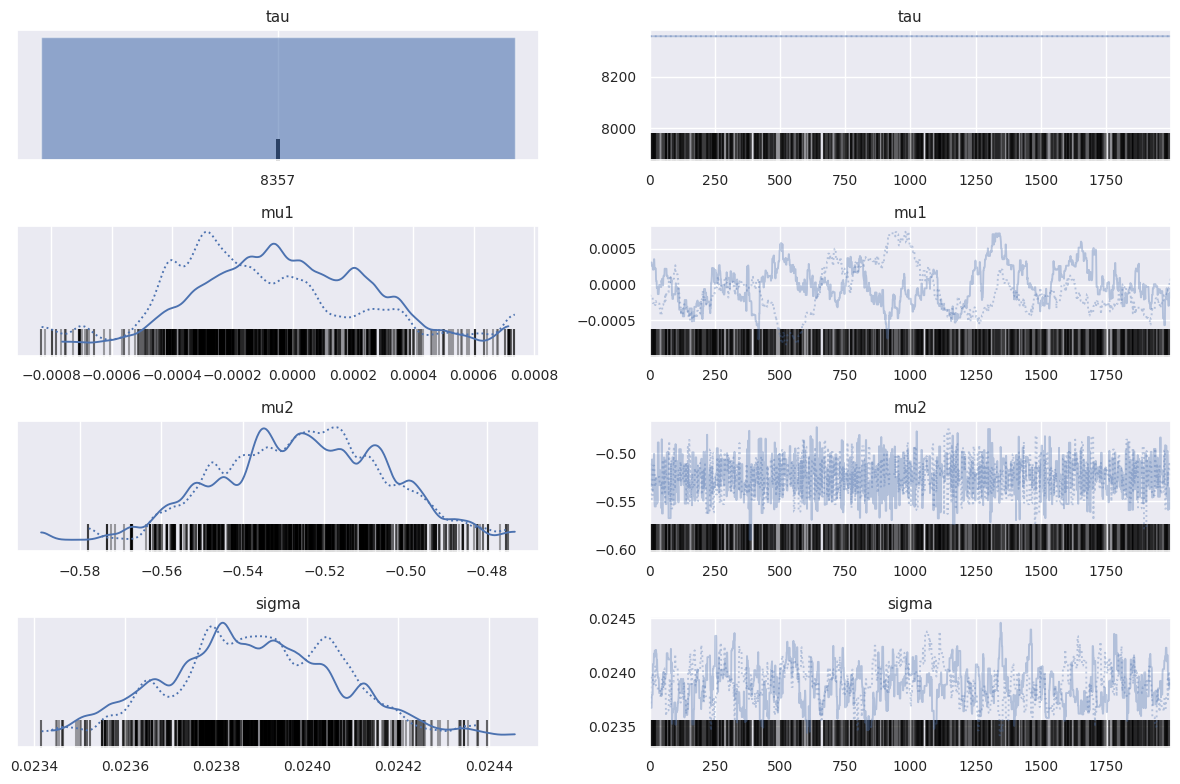

           mean    sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau    8357.000  0.00  8357.000  8357.000      0.000      NaN    4000.0   
mu1      -0.000  0.00    -0.001     0.001      0.000    0.000      37.0   
mu2      -0.525  0.02    -0.563    -0.492      0.001    0.001    1222.0   
sigma     0.024  0.00     0.024     0.024      0.000    0.000     164.0   

       ess_tail  r_hat  
tau      4000.0    NaN  
mu1        63.0   1.05  
mu2       642.0   1.01  
sigma     307.0   1.01  


In [6]:
# 4.1 Trace plots
az.plot_trace(trace, var_names=['tau', 'mu1', 'mu2', 'sigma'])
plt.tight_layout()
plt.show()

# 4.2 Posterior summary
summary = az.summary(trace, var_names=['tau', 'mu1', 'mu2', 'sigma'])
print(summary)


Most probable change point (tau): 8357
Corresponding date: 2020-04-20


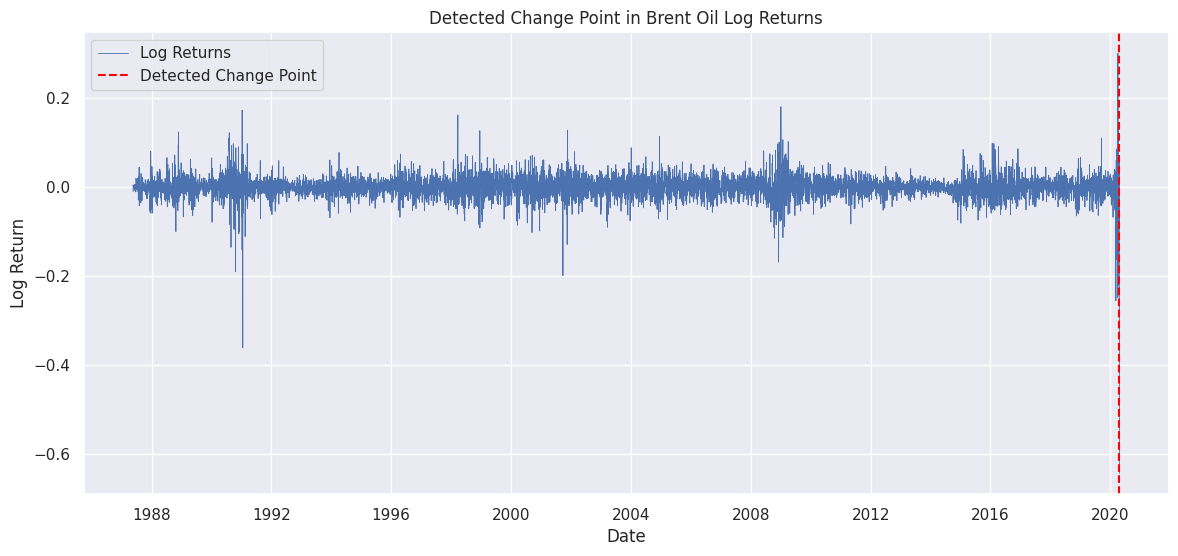

In [7]:
# 5.1 Get most probable change point
tau_posterior = trace.posterior['tau'].values.flatten()
most_probable_tau = int(np.round(np.median(tau_posterior)))

# 5.2 Map tau index to actual date
change_date = df['Date'].iloc[most_probable_tau]
print(f"Most probable change point (tau): {most_probable_tau}")
print(f"Corresponding date: {change_date.strftime('%Y-%m-%d')}")

# 5.3 Plot log returns with change point
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Log_Returns'], label='Log Returns', linewidth=0.6)
plt.axvline(change_date, color='red', linestyle='--', label='Detected Change Point')
plt.title('Detected Change Point in Brent Oil Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# 6.1 Compare means before and after
before_mean = df['Log_Returns'].iloc[:most_probable_tau].mean()
after_mean = df['Log_Returns'].iloc[most_probable_tau:].mean()

print(f"Mean log return BEFORE change: {before_mean:.5f}")
print(f"Mean log return AFTER change:  {after_mean:.5f}")
print(f"Change: {100 * (after_mean - before_mean):.2f}%")


Mean log return BEFORE change: 0.00001
Mean log return AFTER change:  -0.38634
Change: -38.63%


In [9]:
import arviz as az

# Summary of the trace
summary = az.summary(trace, var_names=["tau", "mu1", "mu2"])
print(summary)

# Get the mean values
tau_mean = int(summary.loc["tau", "mean"])
mu1_mean = summary.loc["mu1", "mean"]
mu2_mean = summary.loc["mu2", "mean"]

print(f"Most probable change point index: {tau_mean}")
print(f"Mean before change point (mu1): {mu1_mean:.5f}")
print(f"Mean after change point (mu2): {mu2_mean:.5f}")

         mean    sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau  8357.000  0.00  8357.000  8357.000      0.000      NaN    4000.0   
mu1    -0.000  0.00    -0.001     0.001      0.000    0.000      37.0   
mu2    -0.525  0.02    -0.563    -0.492      0.001    0.001    1222.0   

     ess_tail  r_hat  
tau    4000.0    NaN  
mu1      63.0   1.05  
mu2     642.0   1.01  
Most probable change point index: 8357
Mean before change point (mu1): -0.00000
Mean after change point (mu2): -0.52500
